In [ ]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

2.7.1+cu118
True
NVIDIA GeForce RTX 3050 Laptop GPU


In [ ]:

import os
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm

# Custom functions from the src folder (from FMM-Head)
from src.dataset_loaders import get_ptb_xl_fmm_dataset, get_shaoxing_fmm_dataset

# Custom functions and model from your project (make sure they are updated)
from src.models.VAE import VAE1D, compute_scores

from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, r2_score

In [3]:
%load_ext autoreload
%autoreload 2

In [ ]:

from src.utils import find_data_subfolder

DATA_DIR = find_data_subfolder('')

In [5]:
print("Loading FMM-enhanced PTB-XL dataset...")
data_dict_ptb_xl = get_ptb_xl_fmm_dataset(
    datapath=DATA_DIR,
    num_leads=1,
    lead=0,
    num_waves=5,
    sequence_length=2048,
    delete_high_A=False
)
print("Dataset loaded successfully.")

Loading FMM-enhanced PTB-XL dataset...
Loading "train" folder


100%|██████████| 95868/95868 [11:21<00:00, 140.61it/s]


Loading "test" folder


100%|██████████| 10907/10907 [01:14<00:00, 147.18it/s]


Dataset loaded successfully.


In [6]:
# print("Loading FMM-enhanced Shaoxing dataset...")
# data_dict_shaoxing = get_shaoxing_fmm_dataset( 
#     datapath=DATA_DIR,
#     num_leads=1,
#     lead=0,  
#     num_waves=5,
#     sequence_length=2048,
#     delete_high_A=False
# )
# print("Dataset loaded successfully.")

In [6]:
data_dict = data_dict_ptb_xl  # Usar solo PTB-XL por ahora

### Preprocess

In [7]:
import copy

def reduce_to_batch(list_data, in_batch_size):
    # Remove samples that do no fit in batch
    out_list = []
    num_0_samples = list_data[0].shape[0]
    num_batched_samples = int(num_0_samples/in_batch_size)*in_batch_size
    for x in list_data:
        num_x_samples = x.shape[0]
        assert num_x_samples == num_0_samples
        new_x = x[:num_batched_samples]
        out_list.append(new_x)
    return out_list

def preprocess_data_ptb_xl_fmm(input_data, dataset_params, **kwargs):
    #Simple preprocessing for ptb_xl_fmm, which is loaded already processed
    data = input_data["data"]
    labels  = input_data["labels"]
    sizes  = input_data["sizes"]
    coefficients  = input_data["coefficients"]
    coefficients_ang  = input_data["coefficients_ang"]
    fs = kwargs["fs"]
    batch_size = kwargs["batch_size"]
    split_ecg = kwargs["split_ecg"]
    classes = dataset_params["classes"]
    data_preprocessed = copy.deepcopy(data.astype(np.float32)) 
    labels_preprocessed = copy.deepcopy(labels)
    while(data_preprocessed.ndim<3): # Expand dimensions until we get 3 dimensions (sample, )
        data_preprocessed = np.expand_dims(data_preprocessed, axis=-1).astype(np.float32)
    data_preprocessed,labels_preprocessed,sizes,coefficients,coefficients_ang = \
        reduce_to_batch([data_preprocessed,labels_preprocessed,sizes,coefficients,coefficients_ang],in_batch_size=batch_size)
    num_samples_per_class = [np.sum(labels_preprocessed==i) for i in range(len(classes))] 
    print(f"Number of samples per class: {num_samples_per_class}")
    data_dict = {"data":data_preprocessed,"labels":labels_preprocessed, "sizes":sizes,"coefficients":coefficients,"coefficients_ang":coefficients_ang}       
    return data_dict

def preprocess_data_shaoxing_fmm(input_data, dataset_params, **kwargs):
    return preprocess_data_ptb_xl_fmm(input_data,dataset_params,**kwargs)

In [10]:
raw_dev = {
    "data":            data_dict["train"]["data"], 
    "labels":          data_dict["train"]["labels"],
    "sizes":           data_dict["train"]["sizes"],
    "coefficients":    data_dict["train"]["coefficients"],
    "coefficients_ang":data_dict["train"]["coefficients_ang"],
}
dev_proc = preprocess_data_ptb_xl_fmm( 
    raw_dev,
    dataset_params=data_dict["params"],
    fs=100,
    batch_size=32,
    split_ecg=False
)

raw_test = {
    "data":            data_dict["test"]["data"], 
    "labels":          data_dict["test"]["labels"],
    "sizes":           data_dict["test"]["sizes"],
    "coefficients":    data_dict["test"]["coefficients"],
    "coefficients_ang":data_dict["test"]["coefficients_ang"],
}

test_proc = preprocess_data_ptb_xl_fmm(
    raw_dev,
    dataset_params=data_dict["params"],
    fs=100,
    batch_size=32,
    split_ecg=False
)

Number of samples per class: [np.int64(10950), np.int64(3019), np.int64(14707), np.int64(54050), np.int64(13114)]
Number of samples per class: [np.int64(10950), np.int64(3019), np.int64(14707), np.int64(54050), np.int64(13114)]


In [ ]:
X_dev_signal_raw = data_dict['train']['data'].astype(np.float32)
X_dev_coeffs_raw = data_dict['train']['coefficients'].astype(np.float32)
y_dev = data_dict['train']['labels'].astype(int)

X_test_signal_raw = data_dict['test']['data'].astype(np.float32)
X_test_coeffs_raw = data_dict['test']['coefficients'].astype(np.float32)
y_test = data_dict['test']['labels'].astype(int)

print("Data loading complete.")
print(f"Train signal shape: {X_dev_signal_raw.shape}, Train coeffs shape: {X_dev_coeffs_raw.shape}")

Data loading complete.
Train signal shape: (95868, 2048, 1), Train coeffs shape: (95868, 21)


In [12]:
normal_class_id = data_dict['params']['normal_class']

dev_norm_signal_raw = X_dev_signal_raw[y_dev == normal_class_id]
dev_norm_coeffs_raw = X_dev_coeffs_raw[y_dev == normal_class_id]
dev_ano_signal_raw = X_dev_signal_raw[y_dev != normal_class_id] 
dev_ano_coeffs_raw = X_dev_coeffs_raw[y_dev != normal_class_id]

#### Tensors

In [13]:
dev_norm_signal_tensor_raw = torch.tensor(dev_norm_signal_raw).permute(0, 2, 1)
dev_ano_signal_tensor_raw = torch.tensor(dev_ano_signal_raw).permute(0, 2, 1)

dev_norm_coeffs_tensor_raw = torch.tensor(dev_norm_coeffs_raw)
dev_ano_coeffs_tensor_raw = torch.tensor(dev_ano_coeffs_raw)

### Normalize the data

In [14]:
mean_x = dev_norm_signal_raw.mean()
std_x  = dev_norm_signal_raw.std()
mean_c = dev_norm_coeffs_raw.mean(axis=0)
std_c  = dev_norm_coeffs_raw.std(axis=0)

In [15]:
X_dev_signal = (X_dev_signal_raw - mean_x) / (std_x  + 1e-8)
X_test_signal  = (X_test_signal_raw  - mean_x) / (std_x  + 1e-8)

X_dev_coeffs = (X_dev_coeffs_raw - mean_c) / (std_c  + 1e-8)
X_test_coeffs  = (X_test_coeffs_raw  - mean_c) / (std_c  + 1e-8)

#### Normilized splits

In [16]:
dev_norm_signal = X_dev_signal[y_dev == normal_class_id]
dev_norm_coeffs = X_dev_coeffs[y_dev == normal_class_id]
dev_ano_signal  = X_dev_signal[y_dev != normal_class_id]
dev_ano_coeffs  = X_dev_coeffs[y_dev != normal_class_id]

test_norm_signal = X_test_signal[y_test == normal_class_id]
test_norm_coeffs = X_test_coeffs[y_test == normal_class_id] 
test_ano_signal  = X_test_signal[y_test != normal_class_id]
test_ano_coeffs  = X_test_coeffs[y_test != normal_class_id]

#### Tensors

In [17]:
# Conv1d expects (Batch, Channels, Length)

# Signal Tensors
dev_norm_signal_tensor = torch.tensor(dev_norm_signal).permute(0, 2, 1)
dev_ano_signal_tensor = torch.tensor(dev_ano_signal).permute(0, 2, 1)
test_norm_signal_tensor = torch.tensor(test_norm_signal).permute(0, 2, 1)
test_ano_signal_tensor = torch.tensor(test_ano_signal).permute(0, 2, 1)

# Coefficient Tensors
dev_norm_coeffs_tensor = torch.tensor(dev_norm_coeffs)
dev_ano_coeffs_tensor = torch.tensor(dev_ano_coeffs)
test_norm_coeffs_tensor = torch.tensor(test_norm_coeffs)
test_ano_coeffs_tensor = torch.tensor(test_ano_coeffs)

print(f"VAE training set size (normals only): {len(dev_norm_signal_tensor)}")
print(f"Final test set size (normals): {len(test_norm_signal_tensor)}")

VAE training set size (normals only): 54056
Final test set size (normals): 6042


## Explore the metadata

In [18]:
print(data_dict['train'].keys())


dict_keys(['data', 'coefficients', 'peak_index', 'predicted_coefficients', 'filenames', 'labels', 'sizes', 'coefficients_ang'])


In [ ]:
import pandas as pd

csv_dir = DATA_DIR + "/ptb-xl/1.0.3/ptbxl_database.csv" 
meta_df = pd.read_csv(csv_dir)

In [23]:
df_files = pd.DataFrame({"filename": data_dict["train"]["filenames"]})
df_files["ecg_id"] = (
    df_files["filename"]
      .str.replace("sample_", "")
      .str.replace("_beat_.*", "", regex=True)
      .astype(int)
)
df_merged = df_files.merge(
    meta_df[["ecg_id", "age", "sex", "height", "weight"]],
    on="ecg_id", how="left"
)

print(df_merged.sample(10))

                  filename  ecg_id   age  sex  height  weight
52461   sample_4111_beat_5    4111  80.0  1.0   167.0    75.0
50720   sample_3874_beat_6    3874  52.0  0.0     NaN    70.0
14886  sample_12021_beat_2   12021  69.0  0.0   170.0    62.0
9297   sample_11257_beat_9   11257  77.0  0.0     NaN     NaN
22220    sample_129_beat_2     129  41.0  0.0     NaN    87.0
13462  sample_11835_beat_6   11835  77.0  1.0     NaN     NaN
18755  sample_12537_beat_4   12537  38.0  1.0   173.0    62.0
91806  sample_9442_beat_13    9442  59.0  0.0     NaN     NaN
43285   sample_2856_beat_6    2856  65.0  1.0   168.0    60.0
65603   sample_588_beat_11     588  37.0  0.0     NaN    88.0


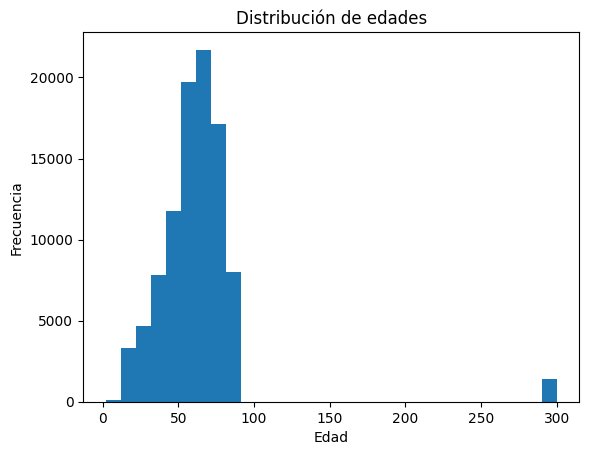

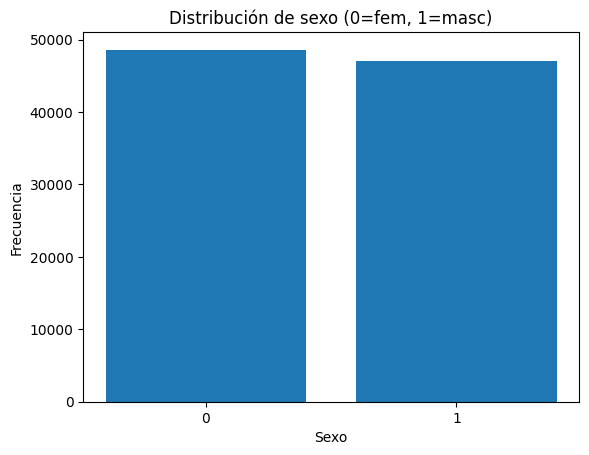

In [24]:
ages_dev_raw    = df_merged["age"].to_numpy()
sexs_dev_raw    = df_merged["sex"].to_numpy()
height_dev_raw  = df_merged["height"].to_numpy()
weight_dev_raw  = df_merged["weight"].to_numpy()

import matplotlib.pyplot as plt

plt.hist(ages_dev_raw, bins=30)
plt.title("Distribución de edades")
plt.xlabel("Edad")
plt.ylabel("Frecuencia")
plt.show()

plt.hist(sexs_dev_raw[sexs_dev_raw >= 0], bins=[-0.5,0.5,1.5], rwidth=0.8)
plt.title("Distribución de sexo (0=fem, 1=masc)")
plt.xticks([0,1])
plt.xlabel("Sexo")
plt.ylabel("Frecuencia")
plt.show()

In [25]:
ages = df_merged["age"]
sexs = df_merged["sex"]

In [26]:
print("Edades mayores a 100:") 
print((ages > 100).sum())

Edades mayores a 100:
1402


In [27]:
print(df_merged["age"].isna().sum())
print(df_merged["sex"].isna().sum())

216
216


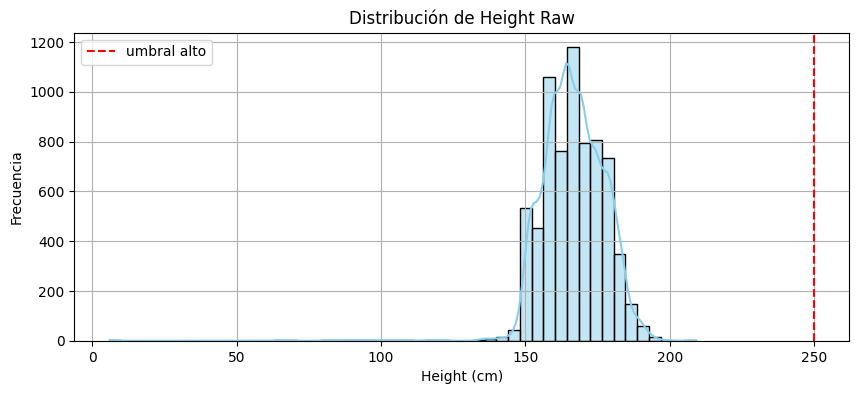

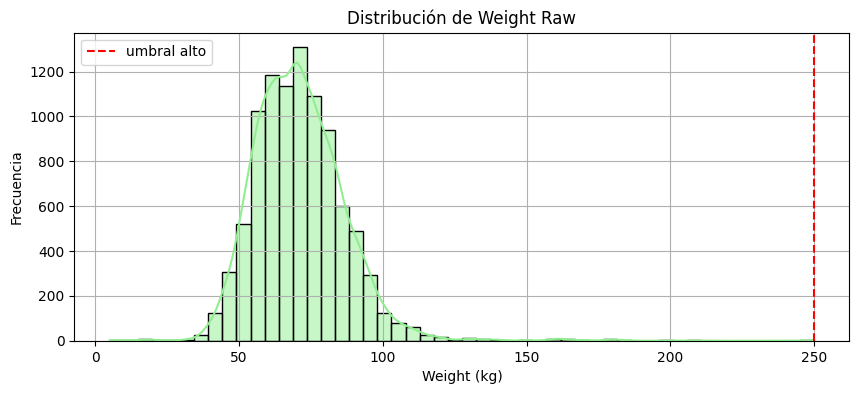

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

height_raw = meta_df["height"] 
weight_raw = meta_df["weight"]

# --- Plot height ---
plt.figure(figsize=(10, 4))
sns.histplot(height_raw, bins=50, kde=True, color="skyblue") 
plt.axvline(250, color='red', linestyle='--', label="umbral alto")
plt.title("Distribución de Height Raw")
plt.xlabel("Height (cm)")
plt.ylabel("Frecuencia")
plt.legend()
plt.grid(True)
plt.show()

# --- Plot weight ---
plt.figure(figsize=(10, 4))
sns.histplot(weight_raw, bins=50, kde=True, color="lightgreen")
plt.axvline(250, color='red', linestyle='--', label="umbral alto")
plt.title("Distribución de Weight Raw")
plt.xlabel("Weight (kg)")
plt.ylabel("Frecuencia")
plt.legend()
plt.grid(True)
plt.show()


In [29]:

# --- 3. Calculá estadísticas SOLO con TRAIN ---
def safe_mean(x, max_reasonable=None):
    """Mean ignorando NaN y outliers (si se da un valor razonable tope)"""
    x_valid = x[~np.isnan(x)]
    if max_reasonable is not None:
        x_valid = x_valid[x_valid <= max_reasonable]
    return x_valid.mean()


mean_age    = safe_mean(ages_dev_raw,   100)
mean_height = safe_mean(height_dev_raw, 250)  # cm
mean_weight = safe_mean(weight_dev_raw, 250)  # kg
mode_sex    = float(pd.Series(sexs_dev_raw).mode()[0])


In [30]:

# --- 4. Imputá TRAIN ---
ages_dev_imp    = np.where(np.isnan(ages_dev_raw) | (ages_dev_raw > 100), mean_age, ages_dev_raw)
sexs_dev_imp    = np.where(np.isnan(sexs_dev_raw), mode_sex, sexs_dev_raw)
height_dev_imp  = np.where(np.isnan(height_dev_raw) | (height_dev_raw > 250) | (height_dev_raw < 50), mean_height, height_dev_raw)
weight_dev_imp  = np.where(np.isnan(weight_dev_raw) | (weight_dev_raw > 250) | (weight_dev_raw < 2.5), mean_weight, weight_dev_raw)


metas_dev_imp = np.stack([ages_dev_imp, sexs_dev_imp, height_dev_imp, weight_dev_imp], axis=1)

In [31]:

# --- 5. TEST: hacé lo mismo, pero usando valores de TRAIN ---
df_files_t = pd.DataFrame({"filename": data_dict["test"]["filenames"]})
df_files_t["ecg_id"] = (
    df_files_t["filename"]
      .str.replace("sample_", "")
      .str.replace("_beat_.*", "", regex=True)
      .astype(int)
)
df_merged_t = df_files_t.merge(
    meta_df[["ecg_id", "age", "sex", "height", "weight"]],
    on="ecg_id", how="left"
)

ages_test_raw    = df_merged_t["age"].to_numpy()
sexs_test_raw    = df_merged_t["sex"].to_numpy()
height_test_raw  = df_merged_t["height"].to_numpy()
weight_test_raw  = df_merged_t["weight"].to_numpy()

ages_test_imp    = np.where(np.isnan(ages_test_raw) | (ages_test_raw > 100), mean_age, ages_test_raw)
sexs_test_imp    = np.where(np.isnan(sexs_test_raw), mode_sex, sexs_test_raw)
height_test_imp  = np.where(np.isnan(height_test_raw) | (height_test_raw > 250) | (height_test_raw < 50), mean_height, height_test_raw)
weight_test_imp  = np.where(np.isnan(weight_test_raw) | (weight_test_raw > 250) | (weight_test_raw < 2.5), mean_weight, weight_test_raw)


metas_test_imp = np.stack([ages_test_imp, sexs_test_imp, height_test_imp, weight_test_imp], axis=1)


In [32]:

# --- 6. Separá por clase y convertí a tensores ---
normal_id = data_dict["params"]["normal_class"]
y_dev = data_dict["train"]["labels"].astype(int)
y_test  = data_dict["test"]["labels"].astype(int)

dev_norm_meta_raw = metas_dev_imp[y_dev == normal_id]
dev_ano_meta_raw  = metas_dev_imp[y_dev != normal_id]

test_norm_meta = metas_test_imp[y_test == normal_id]
test_ano_meta  = metas_test_imp[y_test != normal_id]

dev_norm_meta_tensor_raw = torch.tensor(dev_norm_meta_raw, dtype=torch.float32)
dev_ano_meta_tensor_raw  = torch.tensor(dev_ano_meta_raw,  dtype=torch.float32)
test_norm_meta_tensor = torch.tensor(test_norm_meta, dtype=torch.float32)
test_ano_meta_tensor  = torch.tensor(test_ano_meta,  dtype=torch.float32)

print("✅ Metadatos con age, sex, height, weight procesados:")
print(f"  Dev normales:    {dev_norm_meta_tensor_raw.shape}")
print(f"  Dev anomalías:   {dev_ano_meta_tensor_raw.shape}")
print(f"  Test normales:   {test_norm_meta_tensor.shape}")
print(f"  Test anomalías:  {test_ano_meta_tensor.shape}")

✅ Metadatos con age, sex, height, weight procesados:
  Dev normales:    torch.Size([54056, 4])
  Dev anomalías:   torch.Size([41812, 4])
  Test normales:   torch.Size([6042, 4])
  Test anomalías:  torch.Size([4865, 4])


In [33]:
# --- 5b. Normalizá usando SOLO normales de TRAIN ---
mean_meta = dev_norm_meta_raw.mean(axis=0)
std_meta  = dev_norm_meta_raw.std(axis=0)

# Evitá división por cero
std_meta[std_meta == 0] = 1.0

metas_dev_norm = (metas_dev_imp - mean_meta) / std_meta
metas_test_norm  = (metas_test_imp  - mean_meta) / std_meta


In [34]:
dev_norm_meta = metas_dev_norm[y_dev == normal_id]
dev_ano_meta  = metas_dev_norm[y_dev != normal_id]

test_norm_meta = metas_test_norm[y_test == normal_id]
test_ano_meta  = metas_test_norm[y_test != normal_id]

In [35]:
dev_norm_meta_tensor = torch.tensor(dev_norm_meta, dtype=torch.float32)
dev_ano_meta_tensor  = torch.tensor(dev_ano_meta,  dtype=torch.float32)

test_norm_meta_tensor = torch.tensor(test_norm_meta, dtype=torch.float32)
test_ano_meta_tensor  = torch.tensor(test_ano_meta,  dtype=torch.float32)

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

X_meta = np.vstack([dev_norm_meta, dev_ano_meta])
y_meta = np.concatenate([np.zeros(len(dev_norm_meta)), np.ones(len(dev_ano_meta))])


clf_meta = XGBClassifier()
clf_meta.fit(X_meta, y_meta)
probs_meta = clf_meta.predict_proba(X_meta)[:,1]

print("ROC AUC sobre metadatos:", roc_auc_score(y_meta, probs_meta))

ROC AUC sobre metadatos: 0.7559610606397869


## La conclusión es que los metadatos como age, sex, height o weight no aportan información relevante